![Crisp](img/logo.png)
# <img src="img/Blueprints-Distribution Expansion.png" alt="icon" width="40"/> Distribution Expansion


[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_distribution_expansion.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_distribution_expansion.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_distribution_expansion.ipynb)


> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select Import and choose URL as the import method.
> 4. Paste the notebook's URL and click Import to complete the process.

This notebook demonstrates a data-driven approach to generate distribution expansion recommendations for retail stores by:
1. Clustering stores based on their subcategory sales mix
2. Calculating product velocity metrics within each cluster
3. Identifying top-performing products by subcategory and cluster
4. Generating personalized product recommendations for each store
5. Estimating financial impact and prioritizing recommendations

The goal is to identify products that should be added to specific stores to maximize sales potential based on similar store performance.

In [1]:
import os

os.environ["ACCOUNT_ID"] = "777777"
# os.environ["CONNECTOR_ID"] = None

### Run Crisp common notebook

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import Required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
warnings.filterwarnings("ignore")

%matplotlib inline

## Load necessary data

We will use following tables in this tutorial.

In [4]:
src_project = project
src_dataset = dataset

dim_product = "exp_normalized_dim_product"
dim_sub_category = "exp_normalized_dim_product_sub_category"
dim_category = "exp_normalized_dim_product_category"
dim_store = "exp_normalized_dim_store"
fact_sales = "exp_normalized_fact_sales"

category = "Phones & Tablets"

In [5]:
# Define period in weeks to perform the analysis. This will be used to aggregate the sales data.
weeks = 13  # Last 13 weeks will be used in the analysis.
days_lookback = weeks * 7  # Convert weeks to days.

In [6]:
%%load sales_data
WITH
  latest_date AS (
  SELECT
    MAX(date_key) AS max_date
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}` ),
  product AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_product}` ),
  product_sub_category AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_sub_category}` ),
  product_category AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_category}` ),
  store AS (
  SELECT
    *
  FROM
    `{src_project}`.`{src_dataset}`.`{dim_store}` ),
  sales AS (
  SELECT
    product_id,
    store_id,
    SUM(sales_amount) AS dollar_amount,
    SUM(sales_quantity) AS unit_amount
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`,
    latest_date
  WHERE
    date_key > DATE_ADD(max_date, INTERVAL -{days_lookback} DAY)
  GROUP BY
    product_id,
    store_id ),
  salesYA AS (
  SELECT
    product_id,
    store_id,
    SUM(sales_amount) AS dollar_amount_YA,
    SUM(sales_quantity) AS unit_amount_YA
  FROM
    `{src_project}`.`{src_dataset}`.`{fact_sales}`,
    latest_date
  WHERE
    date_key > DATE_ADD(max_date, INTERVAL (-{days_lookback}-365) DAY)
    AND date_key < DATE_ADD(max_date, INTERVAL -365 DAY)
  GROUP BY
    product_id,
    store_id )
SELECT
  store.store,
  store.store_id,
  store.store_state,
  product.product,
  product.product_id,
  product_sub_category.product_sub_category,
  product_category.product_category,
  sales.unit_amount,
  sales.dollar_amount,
  salesYA.unit_amount_YA,
  salesYA.dollar_amount_YA,
FROM
  sales
JOIN
  product
USING
  (product_id)
JOIN
  product_sub_category
USING
  (product_sub_category_id)
JOIN
  product_category
USING
  (product_category_id)
JOIN
  store
USING
  (store_id)
LEFT JOIN
  salesYA
USING
  (product_id,
    store_id)
WHERE
  (product_category.product_category = '{category}')
ORDER BY
  product,
  store

,store,store_id,store_state,product,product_id,product_sub_category,product_category,unit_amount,dollar_amount,unit_amount_YA,dollar_amount_YA
0,STORE 10070,652456303622673632,MI,LunaBook Pro,124,Smartphones,Phones & Tablets,339,16831.35,347,17228.55
1,STORE 10225,528560067038876100,MI,LunaBook Pro,124,Smartphones,Phones & Tablets,307,21769.37,326,23116.66
2,STORE 10259,759598227039054229,MI,LunaBook Pro,124,Smartphones,Phones & Tablets,347,27971.67,353,28455.33
3,STORE 11608,303434382897882916,IL,LunaBook Pro,124,Smartphones,Phones & Tablets,320,22019.20,336,23120.16
4,STORE 12156,588572080144839732,MO,LunaBook Pro,124,Smartphones,Phones & Tablets,331,28707.63,330,28620.90
...,...,...,...,...,...,...,...,...,...,...,...
1430,STORE 8639,306204143441551800,OH,LunaTech Verse,120,Tablets,Phones & Tablets,420,38560.20,426,39111.06
1431,STORE 8676,442672529938553764,OH,LunaTech Verse,120,Tablets,Phones & Tablets,427,6443.43,419,6322.71
1432,STORE 8782,637932436068076842,OH,LunaTech Verse,120,Tablets,Phones & Tablets,425,31110.00,455,33306.00
1433,STORE 8879,600614578681889992,OH,LunaTech Verse,120,Tablets,Phones & Tablets,412,29445.64,462,33019.14


In [7]:
# Transform relevant columns to float and drop duplicates
sales_data = sales_data.apply(pd.to_numeric, errors="ignore").drop_duplicates()

# replace NaN with 0
sales_data = sales_data.fillna(0)

In [8]:
print(
    f"There are {len(sales_data)} sales records across {sales_data['store'].nunique()} stores and {sales_data['product'].nunique()} products"
)
print(f"Number of subcategories: {sales_data['product_sub_category'].nunique()}")
print(f"Number of categories: {sales_data['product_category'].nunique()}")

There are 1435 sales records across 100 stores and 20 products
Number of subcategories: 2
Number of categories: 1


## Calculate Sales Metrics

Now we'll calculate key metrics that will be used for our analysis, including:
- Dollar and unit velocity (sales per week)
- Growth rates (year-over-year)
- Price per unit

In [9]:
def calculate_sales_metrics(df, weeks=13):
    """Calculate key sales metrics from the raw sales data."""
    # Create a copy to avoid modifying the original
    sales_metrics = df.copy()

    # Calculate dollar velocity ($ per store per week)
    sales_metrics["dollar_velocity"] = sales_metrics["dollar_amount"] / weeks
    sales_metrics["dollar_velocity_YA"] = sales_metrics["dollar_amount_YA"] / weeks

    # Calculate unit velocity (units per store per week)
    sales_metrics["unit_velocity"] = sales_metrics["unit_amount"] / weeks
    sales_metrics["unit_velocity_YA"] = sales_metrics["unit_amount_YA"] / weeks

    # Calculate growth and growth rates
    sales_metrics["dollar_growth"] = (
        sales_metrics["dollar_velocity"] - sales_metrics["dollar_velocity_YA"]
    )
    sales_metrics["unit_growth"] = (
        sales_metrics["unit_velocity"] - sales_metrics["unit_velocity_YA"]
    )

    # Handle division by zero in growth rate calculations
    # Replace zeros with a small number to avoid division by zero
    dollar_vel_ya_adj = sales_metrics["dollar_velocity_YA"].replace(0, 0.01)
    unit_vel_ya_adj = sales_metrics["unit_velocity_YA"].replace(0, 0.01)

    sales_metrics["dollar_growth_rate"] = (
        sales_metrics["dollar_growth"] / dollar_vel_ya_adj
    )
    sales_metrics["unit_growth_rate"] = sales_metrics["unit_growth"] / unit_vel_ya_adj

    # Clean up any remaining NaN values
    sales_metrics = sales_metrics.fillna(0)

    return sales_metrics


# Calculate sales metrics
sales_metrics = calculate_sales_metrics(sales_data)

sales_metrics[
    [
        "store",
        "product",
        "dollar_velocity",
        "unit_velocity",
        "dollar_growth_rate",
        "unit_growth_rate",
    ]
]

,store,product,dollar_velocity,unit_velocity,dollar_growth_rate,unit_growth_rate
0,STORE 10070,LunaBook Pro,1294.719231,26.076923,-0.023055,-0.023055
1,STORE 10225,LunaBook Pro,1674.566923,23.615385,-0.058282,-0.058282
2,STORE 10259,LunaBook Pro,2151.666923,26.692308,-0.016997,-0.016997
3,STORE 11608,LunaBook Pro,1693.784615,24.615385,-0.047619,-0.047619
4,STORE 12156,LunaBook Pro,2208.279231,25.461538,0.003030,0.00303
...,...,...,...,...,...,...
1430,STORE 8639,LunaTech Verse,2966.169231,32.307692,-0.014085,-0.014085
1431,STORE 8676,LunaTech Verse,495.648462,32.846154,0.019093,0.019093
1432,STORE 8782,LunaTech Verse,2393.076923,32.692308,-0.065934,-0.065934
1433,STORE 8879,LunaTech Verse,2265.049231,31.692308,-0.108225,-0.108225


## Cluster Stores by Subcategory Sales Mix

We'll cluster stores based on their subcategory sales mix and total sales amount to identify groups of similar stores. This will help us make more relevant product recommendations.
The implementation below follows the same algorithm as the clustering blueprint. Please refer to it for a more detailed implementation [crisp_store_clustering.ipynb](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_store_clustering.ipynb) .

In [10]:
def cluster_stores_by_subcategory_mix(
    df, n_clusters=4, include_store_size=True, store_size_weight=1.0
):
    """Cluster stores based on their subcategory sales mix and store total sales."""
    # Create a pivot table with stores as rows and subcategories as columns
    store_subcat_qty = df.pivot_table(
        index="store",
        columns="product_sub_category",
        values="unit_amount",
        aggfunc="sum",
        fill_value=0,
    )

    # Convert to percentages (normalize by store total)
    store_totals = store_subcat_qty.sum(axis=1)
    store_subcat_pct = store_subcat_qty.div(store_totals, axis=0)

    # Add store size as a feature if requested
    if include_store_size:
        # Create a DataFrame with store size (total sales)
        store_size_df = pd.DataFrame(store_totals, columns=["store_size"])

        # Combine subcategory mix with store size
        combined_features = store_subcat_pct.copy()
        combined_features["store_size"] = store_size_df["store_size"]

        # Scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(combined_features)

        # Apply weight to the store size feature (last column)
        if store_size_weight != 1.0:
            scaled_data[:, -1] = scaled_data[:, -1] * store_size_weight
    else:
        # Scale only the subcategory mix data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(store_subcat_pct)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)

    # Create a mapping of store to cluster
    store_cluster_map = pd.DataFrame(
        {"store": store_subcat_pct.index, "cluster": clusters}
    )

    # Return the features data used for clustering
    if include_store_size:
        return store_cluster_map, combined_features, scaled_data
    else:
        return store_cluster_map, store_subcat_pct, scaled_data


# Cluster the stores
store_clusters, features, scaled_data = cluster_stores_by_subcategory_mix(sales_metrics)

# Convert scaled_data back to a DataFrame with the same structure as features
scaled_features = pd.DataFrame(
    scaled_data, index=features.index, columns=features.columns
)

# Add cluster assignment back to the sales data - This step can be modified to load the cluster assignment from the store_clusters blueprint.
sales_metrics = sales_metrics.merge(store_clusters, on="store", how="left")

print("Cluster Distribution:")
print(sales_metrics.groupby("cluster")["store"].nunique())

Cluster Distribution:
cluster
0    28
1    32
2    27
3    13
Name: store, dtype: int64


## Identify Top Performing Products by Cluster and Subcategory

Now we'll identify the top-performing products in each cluster and subcategory combination, based on:
1. Dollar velocity (sales per week)
2. Store coverage (percentage of stores selling the product)
3. Growth rate (year-over-year)

We'll focus on products in the top quartile of dollar velocity that are sold in at least 10% of stores within their cluster.

In [11]:
def identify_top_performers(df, min_store_pct=0.1):
    """Identify top performing products by cluster and subcategory."""
    # Group sales data by cluster, subcategory, and product
    grouped = df.groupby(["cluster", "product_sub_category", "product"])

    # Calculate aggregated metrics
    performance = grouped.agg(
        {
            "dollar_velocity": "mean",  # Average dollar velocity across stores
            "unit_velocity": "mean",  # Average unit velocity across stores
            "dollar_growth_rate": "mean",  # Average growth rate
            "store": "nunique",  # Number of stores selling the product
            "product_id": "first",  # Just to keep the product ID
            "product_category": "first",  # Keep the category
        }
    ).reset_index()

    # Rename the store column to store_count
    performance.rename(columns={"store": "store_count"}, inplace=True)

    # Calculate total stores per cluster
    total_stores = df.groupby("cluster")["store"].nunique().reset_index()
    total_stores.columns = ["cluster", "total_cluster_stores"]

    # Join with performance data
    performance = performance.merge(total_stores, on="cluster")

    # Calculate the percentage of stores in each cluster selling each product
    performance["store_coverage"] = (
        performance["store_count"] / performance["total_cluster_stores"]
    )

    # Filter for minimum store coverage
    performance = performance[performance["store_coverage"] >= min_store_pct]

    # Calculate quartiles for dollar velocity within each cluster and subcategory
    def assign_quartile(group):
        group = group.copy()
        if len(group) >= 4:
            # For groups with 4+ items, use qcut for quartiles
            group["velocity_quartile"] = (
                pd.qcut(group["dollar_velocity"], 4, labels=False, duplicates="drop")
                + 1
            )
        else:
            # For small groups, use rank and scale to make highest = 4
            ranks = group["dollar_velocity"].rank(method="dense")
            max_rank = ranks.max()
            group["velocity_quartile"] = ranks * (4 / max_rank)
            # Round to integers if needed
            group["velocity_quartile"] = group["velocity_quartile"].astype(int)
        return group

    # Apply quartile calculation to each cluster-subcategory group
    performance = (
        performance.groupby(["cluster", "product_sub_category"])
        .apply(assign_quartile)
        .reset_index(drop=True)
    )

    # Add a growth bonus to velocity quartile
    # Normalize growth rate to 0-1 range for positive growth
    performance["growth_bonus"] = (performance["dollar_growth_rate"] > 0) * 0.5
    performance["adjusted_quartile"] = (
        performance["velocity_quartile"] + performance["growth_bonus"]
    )

    # Identify top sales performers
    top_performers = performance[performance["adjusted_quartile"] > 3].copy()

    # Ensure we return both the top performers and all performers for reference
    return top_performers, performance


# Identify top performing products
top_performers, all_performance = identify_top_performers(sales_metrics)

# Summarize top performers
print(
    f"Identified {len(top_performers)} top-performing products across {top_performers['cluster'].nunique()} clusters"
)
print("Top performers by subcategory:")
print(top_performers.groupby("product_sub_category").size())

top_performers.head()

Identified 32 top-performing products across 4 clusters
Top performers by subcategory:
product_sub_category
Smartphones    15
Tablets        17
dtype: int64


,cluster,product_sub_category,product,dollar_velocity,unit_velocity,dollar_growth_rate,store_count,product_id,product_category,total_cluster_stores,store_coverage,velocity_quartile,growth_bonus,adjusted_quartile
0,0,Smartphones,LunaBook Pro,1842.245245,25.293706,-0.029574,11,124,Phones & Tablets,28,0.392857,4,0.0,4.0
3,0,Smartphones,LunaPhone Helios,1846.161239,34.141026,0.009000,18,104,Phones & Tablets,28,0.642857,4,0.5,4.5
6,0,Smartphones,LunaPhone Nova,1835.483269,33.301282,0.002607,12,110,Phones & Tablets,28,0.428571,4,0.5,4.5
8,0,Smartphones,LunaPhone Spark,927.676509,19.60355,0.039417,13,106,Phones & Tablets,28,0.464286,3,0.5,3.5
15,0,Tablets,LunaTab X,1796.065808,33.188462,0.014652,20,119,Phones & Tablets,28,0.714286,4,0.5,4.5


## Generate Product Recommendations

Now we'll generate product recommendations for each store based on the top performers in their cluster. 
For each store, we'll recommend products that:
1. Are in the top quartile of their subcategory in the store's cluster
2. Are not currently sold in the store
3. Have a high expected financial impact

We'll also calculate a confidence score based on store similarity and create an implementation priority ranking.

In [12]:
def generate_recommendations(df, top_performers, features):
    """Generate product recommendations with normalized velocity expectations."""
    # Get a list of all clusters
    clusters = df["cluster"].unique()

    # Compute store-product mappings
    store_products_map = {
        store: set(df[df["store"] == store]["product"].unique())
        for store in df["store"].unique()
    }

    # Compute top products by cluster
    cluster_products_map = {}
    for cluster in clusters:
        cluster_top = top_performers[top_performers["cluster"] == cluster]
        cluster_products_map[cluster] = {
            row["product"]: row for _, row in cluster_top.iterrows()
        }

    # Compute selling stores by product and cluster
    selling_stores_map = {}
    for cluster in clusters:
        selling_stores_map[cluster] = {}
        for product in cluster_products_map[cluster]:
            sellers = set(
                df[(df["cluster"] == cluster) & (df["product"] == product)][
                    "store"
                ].unique()
            )
            selling_stores_map[cluster][product] = sellers

    # Create dict of store profiles
    store_profiles = {}
    for store in features.index:
        store_profiles[store] = features.loc[store].values.reshape(1, -1)

    # Calculate store size metrics
    # Sum dollar_amount by store
    store_total_sales = df.groupby("store")["dollar_amount"].sum().to_dict()

    # Calculate average sales by cluster
    cluster_avg_sales = {}
    for cluster in clusters:
        cluster_stores = df[df["cluster"] == cluster]["store"].unique()
        cluster_store_sales = [
            store_total_sales.get(store, 0) for store in cluster_stores
        ]
        # Handle empty cluster case
        if cluster_store_sales:
            cluster_avg_sales[cluster] = sum(cluster_store_sales) / len(
                cluster_store_sales
            )
        else:
            cluster_avg_sales[cluster] = 1.0  # Default to 1 to avoid div by zero

    # Cache for similarity scores
    similarity_cache = {}

    def get_similarity(store1, store2):
        key = (min(store1, store2), max(store1, store2))
        if key not in similarity_cache:
            if store1 in store_profiles and store2 in store_profiles:
                similarity_cache[key] = cosine_similarity(
                    store_profiles[store1], store_profiles[store2]
                )[0][0]
            else:
                similarity_cache[key] = 0.5  # Default if profiles missing
        return similarity_cache[key]

    # Initialize list to store recommendations
    recommendations = []

    for cluster in clusters:
        # Get all stores in this cluster
        cluster_stores = df[df["cluster"] == cluster]["store"].unique()
        cluster_avg = cluster_avg_sales[cluster]

        for store in cluster_stores:
            # Get products already in this store
            store_products = store_products_map.get(store, set())

            # Calculate scaling factor for this store (once per store)
            store_sales = store_total_sales.get(store, cluster_avg)
            scaling_factor = store_sales / cluster_avg if cluster_avg > 0 else 1.0

            # Limit scaling factor to reasonable bounds (0.2 to 5.0)
            scaling_factor = max(0.2, min(5.0, scaling_factor))

            # For each top product in this cluster
            for product, product_row in cluster_products_map[cluster].items():
                # Check if store already sells this product
                if product not in store_products:
                    # Find stores that sell this product in the same cluster
                    selling_stores = selling_stores_map[cluster].get(product, set())

                    # Calculate confidence score based on similarity
                    if selling_stores:
                        similarities = [
                            get_similarity(store, seller)
                            for seller in selling_stores
                            if seller in store_profiles
                        ]
                        confidence = (
                            max(0.0, np.mean(similarities)) if similarities else 0.5
                        )
                    else:
                        confidence = 0.5

                    # Calculate adjusted expected velocity
                    expected_velocity = product_row["dollar_velocity"] * scaling_factor
                    annual_impact = expected_velocity * 52  # 52 weeks in a year

                    # Create recommendation entry
                    recommendations.append(
                        {
                            "store": store,
                            "product": product,
                            "product_id": product_row["product_id"],
                            "subcategory": product_row["product_sub_category"],
                            "category": product_row["product_category"],
                            "cluster": cluster,
                            "expected_velocity": expected_velocity,
                            "base_velocity": product_row["dollar_velocity"],
                            "store_scaling_factor": scaling_factor,
                            "confidence_score": confidence,
                            "annual_sales": annual_impact,
                            "priority_score": confidence * expected_velocity,
                        }
                    )

    recommendations_df = pd.DataFrame(recommendations)

    # Sort by priority score for implementation order
    if not recommendations_df.empty:
        recommendations_df = recommendations_df.sort_values(
            "priority_score", ascending=False
        )

    return recommendations_df


# Generate recommendations
recommendations = generate_recommendations(
    sales_metrics, top_performers, scaled_features
)

print(
    f"Generated {len(recommendations)} product recommendations across {recommendations['store'].nunique()} stores"
)
recommendations

Generated 225 product recommendations across 95 stores


,store,product,product_id,subcategory,category,cluster,expected_velocity,base_velocity,store_scaling_factor,confidence_score,annual_sales,priority_score
74,STORE 3927,LunaPhone Helios,104,Smartphones,Phones & Tablets,0,2528.163336,1846.161239,1.369416,0.874169,131464.493494,2210.042472
76,STORE 3927,LunaTech Verse,120,Tablets,Phones & Tablets,0,2475.079902,1807.397692,1.369416,0.881201,128704.154925,2181.041800
75,STORE 3927,LunaPhone Nova,110,Smartphones,Phones & Tablets,0,2513.540750,1835.483269,1.369416,0.848468,130704.118995,2132.660080
215,STORE 9017,LunaTech Verse,120,Tablets,Phones & Tablets,2,2262.901109,2251.065288,1.005258,0.853934,117670.857659,1932.368792
77,STORE 4686,LunaPhone Nova,110,Smartphones,Phones & Tablets,0,2652.943955,1835.483269,1.445365,0.724955,137953.085681,1923.265312
...,...,...,...,...,...,...,...,...,...,...,...,...
221,STORE 4234,LunaTech Induction Cooktop,180,Tablets,Phones & Tablets,2,1103.820744,1100.914860,1.002640,0.390424,57398.678670,430.958106
16,STORE 18500,LunaTech Verse,120,Tablets,Phones & Tablets,1,1675.490852,1844.416962,0.908412,0.058612,87125.524318,98.204107
15,STORE 18500,LunaPhone Helios,104,Smartphones,Phones & Tablets,1,1673.173426,1841.865888,0.908412,0.038509,87005.018130,64.432294
57,STORE 13971,LunaPhone Nova,110,Smartphones,Phones & Tablets,1,1503.840229,2071.074341,0.726116,0.000000,78199.691888,0.000000


## Analyze Recommendations

Let's analyze our recommendations to understand what they tell us about our stores and products.

Recommendations Summary by Subcategory:
   Subcategory  Unique Products  Unique Stores  Total Annual Sales ($)  \
1      Tablets                6             78            8.989957e+06   
0  Smartphones                5             72            8.562354e+06   

   Avg Confidence  
1        0.795483  
0        0.797060  


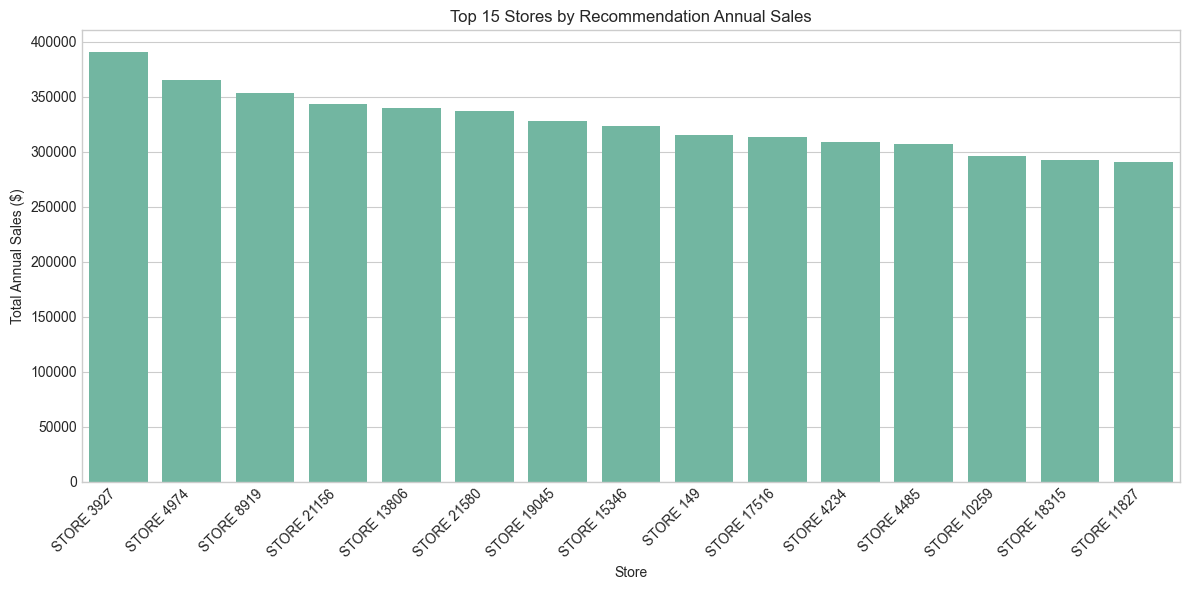

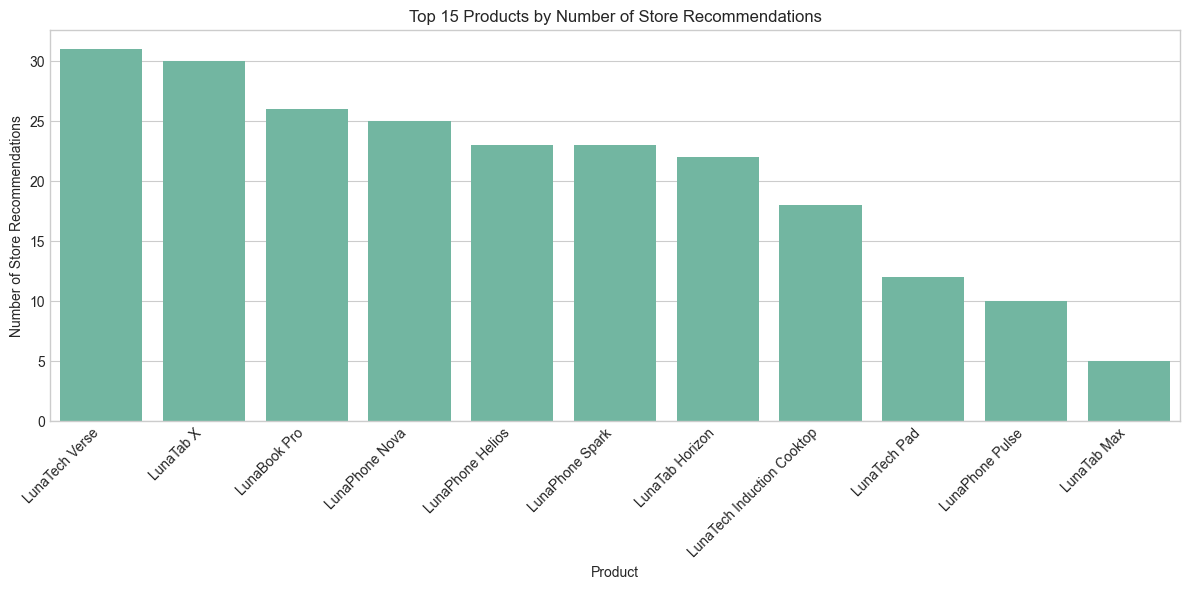

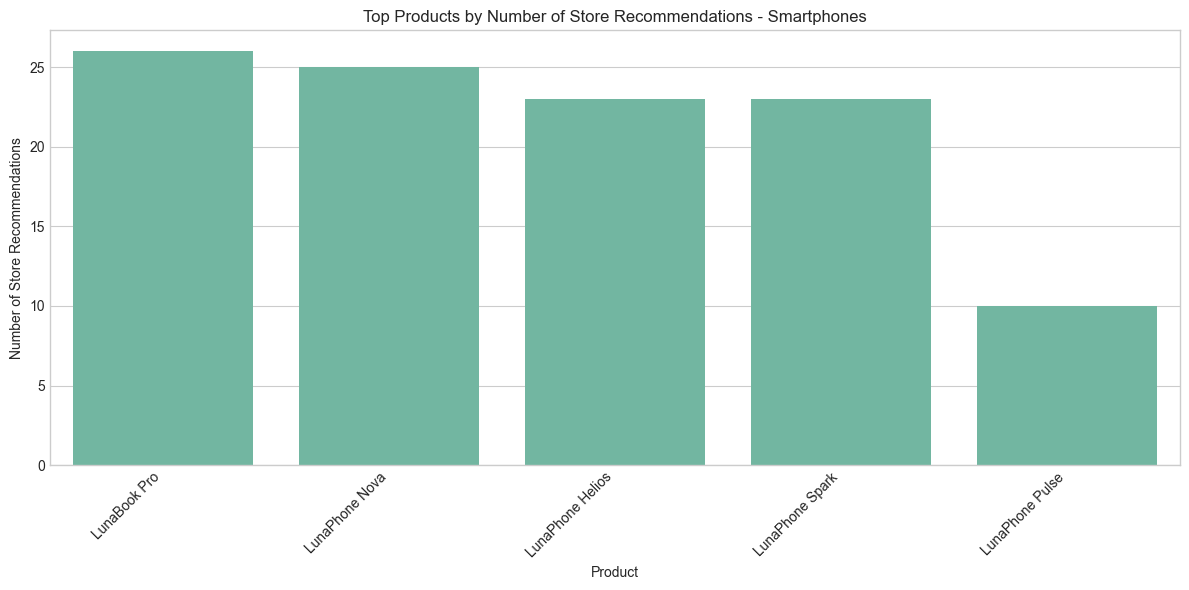

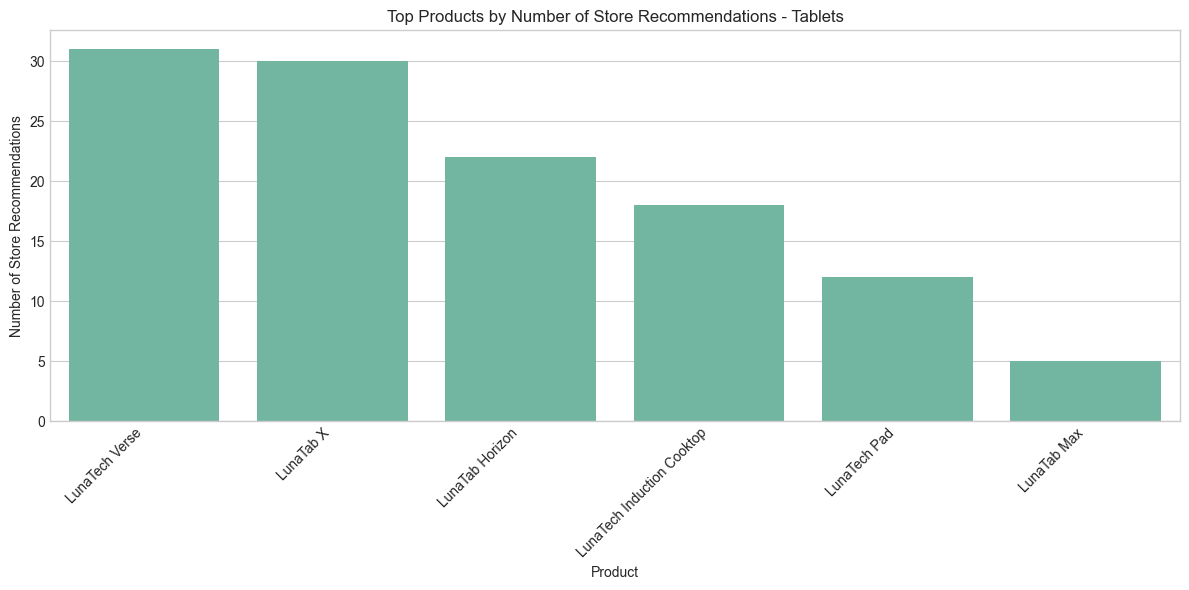

In [13]:
# Summarize recommendations by subcategory
subcat_summary = (
    recommendations.groupby("subcategory")
    .agg(
        {
            "product": "nunique",
            "store": "nunique",
            "annual_sales": "sum",
            "confidence_score": "mean",
        }
    )
    .reset_index()
)

subcat_summary.columns = [
    "Subcategory",
    "Unique Products",
    "Unique Stores",
    "Total Annual Sales ($)",
    "Avg Confidence",
]
subcat_summary = subcat_summary.sort_values("Total Annual Sales ($)", ascending=False)

print("Recommendations Summary by Subcategory:")
print(subcat_summary)

# Top stores by opportunity
store_impact = recommendations.groupby("store")["annual_sales"].sum().reset_index()
store_impact.columns = ["Store", "Total Annual Sales ($)"]
store_impact = store_impact.sort_values("Total Annual Sales ($)", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Store", y="Total Annual Sales ($)", data=store_impact.head(15))
plt.title("Top 15 Stores by Recommendation Annual Sales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Count the number of stores each product is recommended for
product_recommendations = recommendations.groupby("product").size().reset_index()
product_recommendations.columns = ["Product", "Number of Store Recommendations"]
product_recommendations = product_recommendations.sort_values(
    "Number of Store Recommendations", ascending=False
)

# Get the top 15 most recommended products
top_products = product_recommendations.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x="Product", y="Number of Store Recommendations", data=top_products)
plt.title("Top 15 Products by Number of Store Recommendations")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

for subcategory in recommendations["subcategory"].unique():
    # Filter recommendations for this subcategory
    subcat_recs = recommendations[recommendations["subcategory"] == subcategory]

    # Count product recommendations for this subcategory
    subcat_product_recs = subcat_recs.groupby("product").size().reset_index()
    subcat_product_recs.columns = ["Product", "Number of Store Recommendations"]
    subcat_product_recs = subcat_product_recs.sort_values(
        "Number of Store Recommendations", ascending=False
    )

    # Get top products for this subcategory
    top_subcat_products = subcat_product_recs.head(15)

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="Product", y="Number of Store Recommendations", data=top_subcat_products
    )
    plt.title(f"Top Products by Number of Store Recommendations - {subcategory}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## Create Final Output: Product Recommendations for Implementation

Now we'll create the final output that could be shared with business stakeholders for implementation.

In [14]:
# Create a final output with all the details needed for implementation
final_output = recommendations.copy()

# Add store state for reference
final_output = final_output.merge(
    sales_data[["store", "store_state"]].drop_duplicates(), on="store", how="left"
)

final_output["annual_sales"] = final_output["annual_sales"].round(2)
final_output["expected_velocity"] = final_output["expected_velocity"].round(2)
final_output["confidence_score"] = final_output["confidence_score"].round(3)

output_columns = [
    "store",
    "store_state",
    "product",
    "subcategory",
    "category",
    "expected_velocity",
    "annual_sales",
    "confidence_score",
    "priority_score",
]

final_output = final_output[output_columns]
final_output.columns = [
    "Store",
    "State",
    "Product",
    "Subcategory",
    "Category",
    "Expected Weekly Sales ($)",
    "Expected Annual Sales ($)",
    "Confidence Score",
    "Priority Score",
]

final_output = final_output.sort_values("Priority Score", ascending=False)

# Display the top recommendations
print(f"Top 20 product recommendations (out of {len(final_output)}):")
final_output.head(20)

Top 20 product recommendations (out of 225):


,Store,State,Product,Subcategory,Category,Expected Weekly Sales ($),Expected Annual Sales ($),Confidence Score,Priority Score
0,STORE 3927,GA,LunaPhone Helios,Smartphones,Phones & Tablets,2528.16,131464.49,0.874,2210.042472
1,STORE 3927,GA,LunaTech Verse,Tablets,Phones & Tablets,2475.08,128704.15,0.881,2181.041800
2,STORE 3927,GA,LunaPhone Nova,Smartphones,Phones & Tablets,2513.54,130704.12,0.848,2132.660080
3,STORE 9017,OH,LunaTech Verse,Tablets,Phones & Tablets,2262.90,117670.86,0.854,1932.368792
4,STORE 4686,FL,LunaPhone Nova,Smartphones,Phones & Tablets,2652.94,137953.09,0.725,1923.265312
5,STORE 8879,OH,LunaPhone Nova,Smartphones,Phones & Tablets,2139.12,111234.15,0.891,1905.503566
6,STORE 21704,TN,LunaPhone Nova,Smartphones,Phones & Tablets,2312.50,120250.10,0.810,1872.501044
7,STORE 25461,NM,LunaPhone Helios,Smartphones,Phones & Tablets,2048.66,106530.19,0.912,1868.443551
8,STORE 5740,AL,LunaTab X,Tablets,Phones & Tablets,2079.85,108152.16,0.894,1859.261217
9,STORE 8879,OH,LunaTab X,Tablets,Phones & Tablets,2093.18,108845.37,0.862,1803.497395


In [15]:
# Export to CSV if needed
final_output.to_csv("store_product_recommendations.csv", index=False)
print("Recommendations exported to 'store_product_recommendations.csv'")

Recommendations exported to 'store_product_recommendations.csv'
